In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from interstellar import Tracks, Grid, DenseNetwork, set_seed
import os

from tensorflow.keras.optimizers import SGD, Adam

Main difference is testing star age learning

In [2]:
seed = 101
name = 'grid_19'
tracks = 'tracks_04b'
save_path = f'/home/ADF/ajl573/Data/interstellar_data/{name}'
load_path = f'/home/ADF/ajl573/Data/interstellar_data/{tracks}'

In [3]:
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
train = pd.read_csv(f'{load_path}/{tracks}_train.csv')

## Resample

Let's try to resample 80% of the dataset

In [5]:
0.8 * len(train)

6188586.4

For simplicity and batching, I will round this down to 6 million points.

In [6]:
t = Tracks(name=tracks)
t.set_data(train.sample(n=6000000, weights='gradient', random_state=seed))

del train

In [7]:
t.get_data().head()

,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,frac_age,effective_T,luminosity,log_g,surface_he4,surface_Z,star_feh,delta_nu_fit,initial_Zinit,gradient,log_star_age,log_radius
3995955,2,1.08,0.30,0.35,1.9,1.043595,5673.275,1.826398,4.178337,0.259003,0.024350,0.273529,86.067856,0.027260,0.000320,0.870810,0.146389
4415608,2,1.20,0.26,0.25,1.9,1.155536,5632.717,2.945005,4.003852,0.226761,0.020889,0.185828,62.464220,0.023076,0.001583,0.843099,0.256366
219821,2,0.94,0.26,0.25,2.3,1.260279,4816.204,2.492565,3.697376,0.255329,0.022432,0.235659,38.246070,0.023076,0.000526,1.276368,0.356172
1326105,2,0.97,0.24,0.25,2.3,1.184105,5254.683,1.341456,4.131911,0.210687,0.021564,0.190855,81.709206,0.023699,0.001516,1.268245,0.145954
5302363,2,0.80,0.24,-0.10,2.3,1.186145,4891.288,2.689784,3.620810,0.232189,0.010325,-0.121725,34.789745,0.010772,0.000489,1.412521,0.359271


In [8]:
len(t._data)

6000000

## Normalize

Let's choose the inputs and outputs and the normalise

In [9]:
x_cols = ['frac_age', 'initial_mass', 'initial_MLT', 'initial_Yinit', 'initial_Zinit']
y_cols = ['log_star_age', 'effective_T', 'log_radius', 'delta_nu_fit', 'star_feh']

In [10]:
factors, _df = t.normalize(loc='mean', scale='std', columns=x_cols+y_cols)

In [11]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.886590,0.402850
1,initial_mass,initial_mass_norm,0.996833,0.119499
2,initial_MLT,initial_MLT_norm,1.997272,0.338006
3,initial_Yinit,initial_Yinit_norm,0.280062,0.028064
4,initial_Zinit,initial_Zinit_norm,0.018318,0.010699
5,log_star_age,log_star_age_norm,0.784033,0.450751
6,effective_T,effective_T_norm,5528.783927,605.919601
7,log_radius,log_radius_norm,0.142940,0.149972
8,delta_nu_fit,delta_nu_fit_norm,92.475003,42.530333
9,star_feh,star_feh_norm,-0.017718,0.357204


Round the loc and scale to 3 dp

In [12]:
factors = round(factors, 3)

In [13]:
factors

,column,norm_column,loc,scale
0,frac_age,frac_age_norm,0.887,0.403
1,initial_mass,initial_mass_norm,0.997,0.119
2,initial_MLT,initial_MLT_norm,1.997,0.338
3,initial_Yinit,initial_Yinit_norm,0.280,0.028
4,initial_Zinit,initial_Zinit_norm,0.018,0.011
5,log_star_age,log_star_age_norm,0.784,0.451
6,effective_T,effective_T_norm,5528.784,605.920
7,log_radius,log_radius_norm,0.143,0.150
8,delta_nu_fit,delta_nu_fit_norm,92.475,42.530
9,star_feh,star_feh_norm,-0.018,0.357


In [14]:
factors, _df = t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols)
_df.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
3995955,0.388573,0.697479,-0.286982,0.714286,0.841818,0.192484,0.238465,0.022593,-0.150650,0.816607
4415608,0.666342,1.705882,-0.286982,-0.714286,0.461413,0.131040,0.171529,0.755774,-0.705638,0.570948
219821,0.926252,-0.478992,0.896450,-0.714286,0.461413,1.091725,-1.176030,1.421149,-1.275075,0.710530
1326105,0.737234,-0.226891,0.896450,-1.428571,0.518110,1.073714,-0.452372,0.019693,-0.253134,0.585029
5302363,0.742295,-1.655462,0.896450,-1.428571,-0.657099,1.393617,-1.052112,1.441808,-1.356343,-0.290547


In [15]:
del _df

In [16]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
                           columns=x_cols+y_cols, inplace=True)

In [17]:
t.norm_factors.to_csv(os.path.join(save_path, 'tracks_04b_norm.csv'), index=False)

In [18]:
train = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
train.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
3995955,0.388573,0.697479,-0.286982,0.714286,0.841818,0.192484,0.238465,0.022593,-0.150650,0.816607
4415608,0.666342,1.705882,-0.286982,-0.714286,0.461413,0.131040,0.171529,0.755774,-0.705638,0.570948
219821,0.926252,-0.478992,0.896450,-0.714286,0.461413,1.091725,-1.176030,1.421149,-1.275075,0.710530
1326105,0.737234,-0.226891,0.896450,-1.428571,0.518110,1.073714,-0.452372,0.019693,-0.253134,0.585029
5302363,0.742295,-1.655462,0.896450,-1.428571,-0.657099,1.393617,-1.052112,1.441808,-1.356343,-0.290547


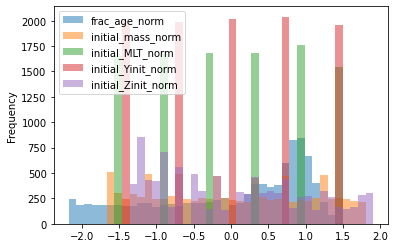

In [19]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in x_cols], bins=40, alpha=0.5)

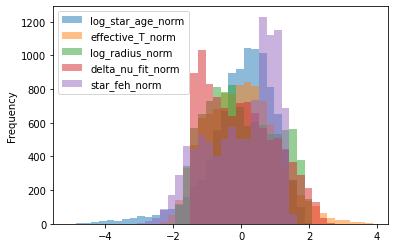

In [20]:
train.sample(n=10000).plot(kind='hist', y=[f'{col}_norm' for col in y_cols], bins=40, alpha=0.5)

Validation

In [21]:
val = pd.read_csv(f'{load_path}/{tracks}_val.csv')

In [22]:
t = Tracks()
t.set_data(val)

In [23]:
t.normalize(loc=factors['loc'].to_numpy(), scale=factors['scale'].to_numpy(),
            columns=x_cols+y_cols, inplace=True)

In [24]:
val = t.get_data([f'{col}_norm' for col in x_cols+y_cols])
val.head()

,frac_age_norm,initial_mass_norm,initial_MLT_norm,initial_Yinit_norm,initial_Zinit_norm,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,-2.144928,0.02521,0.89645,-1.428571,-0.657099,-3.267303,0.389481,-1.339923,1.706118,-0.236674
1,-2.055016,0.02521,0.89645,-1.428571,-0.657099,-2.345807,0.403000,-1.312313,1.651492,-0.249146
2,-2.020283,0.02521,0.89645,-1.428571,-0.657099,-2.140266,0.408372,-1.302933,1.633083,-0.253994
3,-2.013346,0.02521,0.89645,-1.428571,-0.657099,-2.103994,0.409448,-1.301084,1.629465,-0.254954
4,-1.985631,0.02521,0.89645,-1.428571,-0.657099,-1.971340,0.413739,-1.293744,1.615137,-0.258766


In [25]:
del t

In [26]:
x_cols = [f'{col}_norm' for col in x_cols]
y_cols = [f'{col}_norm' for col in y_cols]

In [27]:
print(f'Length of training data = {len(train)}')
print(f'Length of validation data = {len(val)}')

Length of training data = 6000000
Length of validation data = 1933933


In [28]:
n_batches = np.arange(500, 2000)  # Select a range where number of batches is reasonable
r = (len(train)) % n_batches 

# Print whole multiples of training size
print(f'choose number of batches from:\n{n_batches[r==0]}')

choose number of batches from:
[ 500  600  625  640  750  800  960 1000 1200 1250 1500 1600 1875 1920]


In [35]:
14 * 128

1792

In [34]:
8 * 256

2048

In [36]:
depth = [10, 12, 14]
width = [128]
activation = ['elu']
batch_size = [len(train)//600]
regularization_l2 = [0.0]
optimizer = [SGD(0.001, 0.999)]
loss = 'mse'
metrics = ['mae']

In [37]:
def get_config(self):
    config = dict(
        name=self.name,
        model_filename=self.model_filename,
        history_filename=self.history_filename,
        optimizer=str(self.optimizer),
        loss=self.loss,
        metrics=self.metrics,
        x_cols=self.x_cols,
        y_cols=self.y_cols
        )
    return config

In [38]:
DenseNetwork.get_config = get_config

In [39]:
def compile_all(self, loss='mae', metrics=None, **kwargs):
    '''Compile all neural networks on the grid. '''
    self.networks.apply(lambda network: network.compile(
        optimizer=grid.data.loc[grid.data.index==network.name, 'optimizer'].values[0], 
        loss=loss, metrics=metrics, **kwargs))

Grid.compile_all = compile_all

In [40]:
grid = Grid(path=save_path, name=name, depth=depth, width=width,
                        activation=activation, batch_size=batch_size,
                        regularization_l2=regularization_l2, optimizer=optimizer)

grid.data

,depth,width,activation,batch_size,regularization_l2,optimizer
name,,,,,,
grid_19_0,10,128,elu,10000,0.0,<tensorflow.python.keras.optimizer_v2.gradient...
grid_19_1,12,128,elu,10000,0.0,<tensorflow.python.keras.optimizer_v2.gradient...
grid_19_2,14,128,elu,10000,0.0,<tensorflow.python.keras.optimizer_v2.gradient...


In [41]:
grid.make_networks(DenseNetwork, 
                   param_columns=['depth', 'width', 'activation', 'batch_size', 'regularization_l2'])

In [42]:
grid.build_all(len(x_cols), len(y_cols))

In [43]:
grid.compile_all(loss=loss, metrics=metrics)

In [44]:
grid.train_all(train, x_cols, y_cols, epochs=100, validation_data=val, validation_split=None,
               callbacks=['tensorboard'])

Add a function which plots history for all networks.

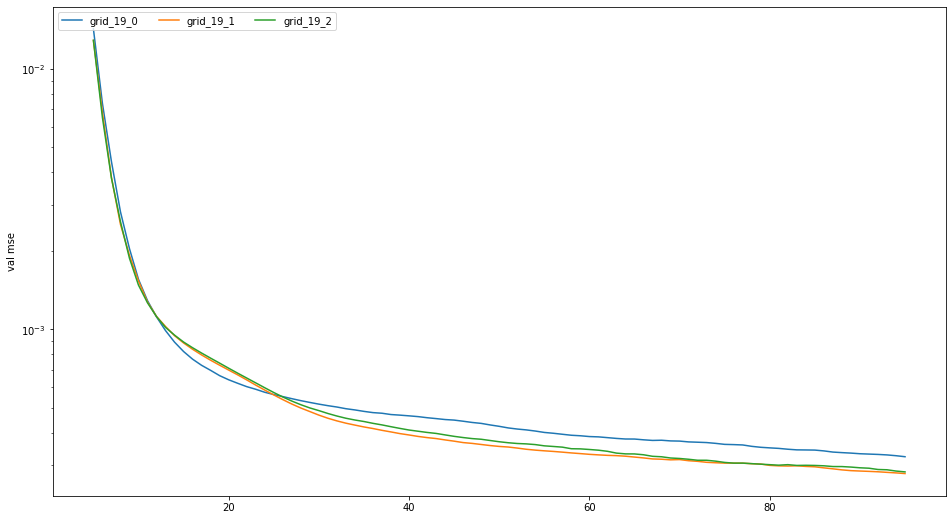

In [45]:
fig, ax = plt.subplots(figsize=(16, 9))
filter_width = 10  # filter width in epochs

for network in grid.networks:
#     network.history.plot(ax=ax, x='epochs', y=['val_loss'], logy=True, alpha=0.5,
#                          label=[f'{network.name} val loss'])
    df = network.history
    y = np.convolve(network.history.val_loss, np.ones((filter_width,))/filter_width, mode='valid')
    ax.plot(df.iloc[filter_width//2:-filter_width//2+1].epochs, y, label=f'{network.name}')
ax.set_ylabel(f'val {loss}')
ax.set_yscale('log')

ax.legend(loc='upper left', ncol=8)

In [77]:
grid.evaluate_all(val.sample(n=5000))

,loss,mae
name,,
grid_14_0,0.858759,0.759292
grid_14_1,0.095538,0.223432
grid_14_2,0.004276,0.038953
grid_14_3,0.000323,0.010431
grid_14_4,0.000497,0.013887


In [78]:
import seaborn as sns

In [79]:
val = val.sample(n=20000)

In [80]:
df_dict = {}
for i, network in enumerate(grid.networks):
#     network = grid.networks[i]
    df_dict[network.name] = np.abs(network.predict(val, batch_size=network.batch_size) - \
                                   val[y_cols].reset_index(drop=True))

In [81]:
df_err = pd.concat(df_dict).reset_index(level=0).rename(columns={'level_0': 'name'})
df_err.head()

,name,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,grid_14_0,0.309210,1.410697,1.656409,0.955168,0.319567
1,grid_14_0,0.543361,1.355196,0.057098,0.007322,1.726662
2,grid_14_0,0.127753,1.270551,0.873890,0.609690,1.167133
3,grid_14_0,0.054319,0.547672,0.184080,0.583556,0.453459
4,grid_14_0,0.524488,0.392607,0.637390,1.062982,0.667788


In [82]:
df_mae = pd.concat(df_dict).mean(axis=1).reset_index(level=0).rename(columns={'level_0': 'name', 0: 'mae'})
df_mae.head()

,name,mae
0,grid_14_0,0.930210
1,grid_14_0,0.737928
2,grid_14_0,0.809803
3,grid_14_0,0.364617
4,grid_14_0,0.657051


In [83]:
df_mae['log_mae'] = np.log10(df_mae['mae'])

In [84]:
order = df_mae.set_index('name').median(level=0).sort_values('log_mae', ascending=False).index

In [85]:
df_err.head()

,name,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
0,grid_14_0,0.309210,1.410697,1.656409,0.955168,0.319567
1,grid_14_0,0.543361,1.355196,0.057098,0.007322,1.726662
2,grid_14_0,0.127753,1.270551,0.873890,0.609690,1.167133
3,grid_14_0,0.054319,0.547672,0.184080,0.583556,0.453459
4,grid_14_0,0.524488,0.392607,0.637390,1.062982,0.667788


In [86]:
df_err_col = df_err.set_index('name').stack().reset_index().rename(columns={'level_1': 'output',
                                                                0: 'abs_err'})

df_err_col['log_abs_err'] = np.log10(df_err_col['abs_err'])

In [87]:
scores = grid.score_all(val, metric='absolute_error')

In [88]:
scores.xs('std', level=1)

,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
grid_14_0,0.643235,0.574155,0.493557,0.423454,0.472105
grid_14_1,0.271089,0.225578,0.210633,0.158817,0.161128
grid_14_2,0.055024,0.061742,0.058473,0.034382,0.047793
grid_14_3,0.008382,0.017800,0.020924,0.011008,0.008095
grid_14_4,0.008465,0.017639,0.024804,0.014418,0.009168


In [89]:
factors.loc[5:, 'scale'].to_numpy() * scores.xs('std', level=1)

,log_star_age_norm,effective_T_norm,log_radius_norm,delta_nu_fit_norm,star_feh_norm
grid_14_0,0.290099,347.891989,0.074034,18.009505,0.168542
grid_14_1,0.122261,136.682166,0.031595,6.754494,0.057523
grid_14_2,0.024816,37.410531,0.008771,1.462274,0.017062
grid_14_3,0.003780,10.785111,0.003139,0.468184,0.002890
grid_14_4,0.003818,10.687905,0.003721,0.613203,0.003273


<IPython.core.display.Javascript object>


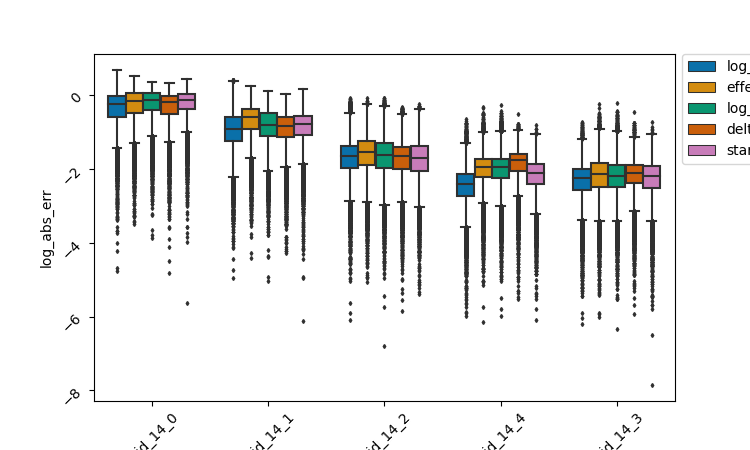

In [90]:
%matplotlib notebook

w = 1.5 * len(grid.data)
fig, ax = plt.subplots(figsize=(w, 4.5))
width = 0.15 * len(y_cols)
sns.boxplot(data=df_err_col, x='name', y='log_abs_err', hue='output',
            width=width, fliersize=2, color='C0', palette='colorblind',
            order=order, ax=ax, saturation=0.9)
# ax.set_yscale('log')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
ax.legend(bbox_to_anchor=(1.0, 1.02))

In [91]:
network = grid.networks[1]

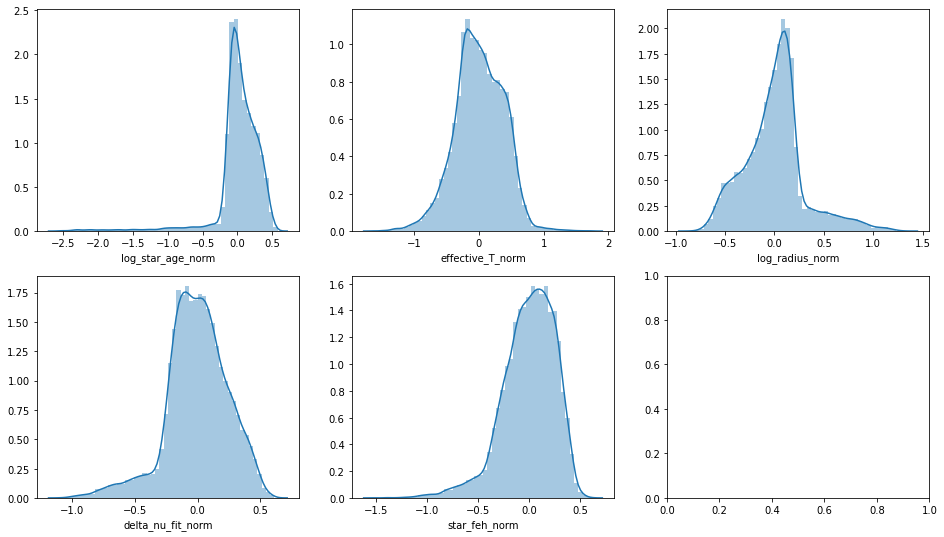

In [92]:
%matplotlib inline

network.plot_metric(val, metric='error', save_plot=False);